# **Fine-tuning para Classificação de Imagens com 🤗 Transformers**

## ImageFolder

## Modelos

* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

- in short, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Data augmentation

* [Albumentations](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb)
* [Kornia](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb)
* [imgaug](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb).

---

Fine-tune a partir do checkpoint https://huggingface.co/microsoft/swin-tiny-patch4-window7-224, outros estão disponíveis via [hub](https://huggingface.co/models?other=vision).

In [ ]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 128 # batch size for training and evaluation

Antes de iniciar, vamos instalar as bibliotecas `datasets` e `transformers`.

In [ ]:
!pip install -q datasets transformers

In [ ]:
from huggingface_hub import login

login()

In [ ]:
!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_classification_notebook", framework="pytorch")

## Fine-tuning para tarefa de classificação de imagem

### Carregando o dataset

In [ ]:
from datasets import load_dataset

# qualquer dataset do hub, como CIFAR-10, FashionMNIST ...
dataset = load_dataset("cifar10")

Carregando métrica de acurácia.

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-30-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
example = dataset["train"][10]
example

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 5}

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 5}

In [ ]:
dataset["train"].features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

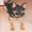

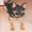

In [ ]:
example['img']

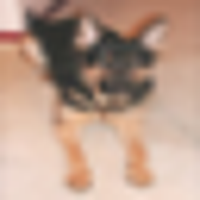

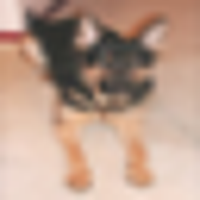

In [ ]:
example['img'].resize((200, 200))

Vamos printar o rótulo correspondente:

In [ ]:
example['label']

5

5

In [ ]:
dataset["train"].features["label"]

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'bird'

'bird'

### Pre-processamento de dados

In [ ]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["img"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["img"]]
    return example_batch

In [ ]:
# fazendo a divisao em datasets de treino em treino + validação
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
train_ds[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 4,
 'pixel_values': tensor([[[ 1.8550,  1.8550,  1.8550,  ...,  1.9235,  1.9235,  1.9235],
          [ 1.8550,  1.8550,  1.8550,  ...,  1.9235,  1.9235,  1.9235],
          [ 1.8550,  1.8550,  1.8550,  ...,  1.9235,  1.9235,  1.9235],
          ...,
          [ 0.9988,  0.9988,  0.9988,  ...,  1.1015,  1.1015,  1.1015],
          [ 0.9988,  0.9988,  0.9988,  ...,  1.1015,  1.1015,  1.1015],
          [ 0.9988,  0.9988,  0.9988,  ...,  1.1015,  1.1015,  1.1015]],
 
         [[ 2.2710,  2.2710,  2.2710,  ...,  2.3410,  2.3410,  2.3410],
          [ 2.2710,  2.2710,  2.2710,  ...,  2.3410,  2.3410,  2.3410],
          [ 2.2710,  2.2710,  2.2710,  ...,  2.3410,  2.3410,  2.3410],
          ...,
          [ 0.4153,  0.4153,  0.4153,  ...,  0.6429,  0.6429,  0.6429],
          [ 0.4153,  0.4153,  0.4153,  ...,  0.6429,  0.6429,  0.6429],
          [ 0.4153,  0.4153,  0.4153,  ...,  0.6429,  0.6429,  0.6429]],
 
  

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 5,
 'pixel_values': tensor([[[ 1.8037,  1.8037,  1.8037,  ..., -1.7412, -1.7412, -1.7412],
          [ 1.8037,  1.8037,  1.8037,  ..., -1.7412, -1.7412, -1.7412],
          [ 1.8037,  1.8037,  1.8037,  ..., -1.7412, -1.7412, -1.7412],
          ...,
          [-0.6281, -0.6281, -0.6281,  ..., -1.1075, -1.1075, -1.1075],
          [-0.6281, -0.6281, -0.6281,  ..., -1.1075, -1.1075, -1.1075],
          [-0.6281, -0.6281, -0.6281,  ..., -1.1075, -1.1075, -1.1075]],
 
         [[ 1.6057,  1.6057,  1.6057,  ..., -1.3880, -1.3880, -1.3880],
          [ 1.6057,  1.6057,  1.6057,  ..., -1.3880, -1.3880, -1.3880],
          [ 1.6057,  1.6057,  1.6057,  ..., -1.3880, -1.3880, -1.3880],
          ...,
          [-0.1275, -0.1275, -0.1275,  ..., -1.2829, -1.2829, -1.2829],
          [-0.1275, -0.1275, -0.1275,  ..., -1.2829, -1.2829, -1.2829],
          [-0.1275, -0.1275, -0.1275,  ..., -1.2829, -1.2829, -1.2829]],
 
  

### Treinando o modelo

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # em caso do fine-tuning de um checkpoint já modificado
)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably T

In [ ]:
!pip install accelerate

In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-cifar10",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    """Computa a acuracia em um batch de predicoes"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return{"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Instaciar o 'Trainer'

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
# Fine tuning do modelo via 'trainer'

train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.601000,0.192679,0.943400
2,0.458100,0.128799,0.957600
3,0.411700,0.114378,0.962000


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 3125805977GF
  train_loss               =       0.6724
  train_runtime            =   0:31:24.87
  train_samples_per_second =       71.623
  train_steps_per_second   =         0.14


In [ ]:
# Checagem de avaliação

metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
trainer.push_to_hub()